Dataset preview:


,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0



Unique labels after mapping: ['Politics' 'Sport' 'Technology' 'Entertainment' 'Business']

Encoding training data...

Evaluating on test data...

Classification Report:
               precision    recall  f1-score   support

     Politics       0.97      0.96      0.97       102
        Sport       0.91      0.92      0.92        77
   Technology       0.97      0.99      0.98        84
Entertainment       1.00      0.98      0.99       102
     Business       0.91      0.91      0.91        80

     accuracy                           0.96       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.96      0.96      0.96       445




Enter a sentence to classify (or 'exit'):  Artificial intelligence continues to reshape the technology landscape in 2025. Major companies like Google, Microsoft, and OpenAI are racing to develop more powerful and efficient AI models capable of understanding and generating human-like language. These innovations are driving advancements across multiple sectors, including healthcare, education, and software development. With the integration of AI into everyday tools, the line between human and machine creativity is becoming increasingly blurred.



Predicted label: Technology
Class probabilities:
Business: 0.196
Sport: 0.112
Entertainment: 0.150
Politics: 0.122
Technology: 0.421


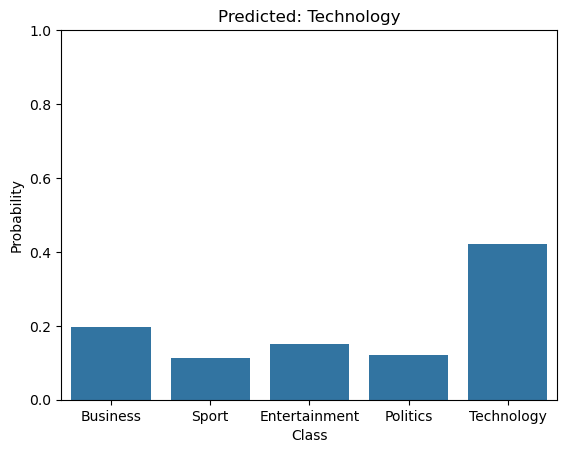

In [ ]:

from transformers import AutoTokenizer, BertModel
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#dataset loading

df = pd.read_csv("df_file.csv")  # replace with your path
print("Dataset preview:")
display(df.head())

# label mapping from dataset

label_mapping = {
    0: "Politics",
    1: "Sport",
    2: "Technology",
    3: "Entertainment",
    4: "Business"
}

if np.issubdtype(df["Label"].dtype, np.number):
    df["Label"] = df["Label"].map(label_mapping)

print("\nUnique labels after mapping:", df["Label"].unique())

#BERT model and tokeniser

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased") # Use BertModel directly
model.eval()

#embedding

def get_embedding(sentence):

    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

#centroid

def calculate_centroid(embeddings):

    return np.mean(embeddings, axis=0)

# train test split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Label"])

# computing embeddings

print("\nEncoding training data...")
train_embeddings = [get_embedding(text) for text in train_df["Text"]]
train_labels = train_df["Label"].tolist()

#computing centriods

centroids = {}
for label in train_df["Label"].unique():
    indices = [i for i, l in enumerate(train_labels) if l == label]
    centroids[label] = calculate_centroid([train_embeddings[i] for i in indices])

#classfication

def classify_sentence(sentence):
    emb = get_embedding(sentence)
    distances = {label: np.linalg.norm(emb - centroid) for label, centroid in centroids.items()}
    similarities = {label: -dist for label, dist in distances.items()}  # smaller distance → higher similarity
    exp_scores = np.exp(list(similarities.values()))
    probs = exp_scores / exp_scores.sum()
    prob_dict = {label: prob for label, prob in zip(similarities.keys(), probs)}
    best_label = max(prob_dict, key=prob_dict.get)
    return best_label, prob_dict

#plotting probabilities

def plot_probabilities(prob_dict, title="Class Probabilities"):
    labels = list(prob_dict.keys())
    probs = [prob_dict[label] for label in labels]
    sns.barplot(x=labels, y=probs)
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("Probability")
    plt.xlabel("Class")
    plt.show()

#evaluation

print("\nEvaluating on test data...")
test_predictions = []
for text in test_df["Text"]:
    pred, _ = classify_sentence(text)
    test_predictions.append(pred)

print("\nClassification Report:")
print(classification_report(test_df["Label"], test_predictions, target_names=list(label_mapping.values())))

#input from user

while True:
    user_input = input("\nEnter a sentence to classify (or 'exit'): ")
    if user_input.lower() == "exit":
        break
    label, prob_dict = classify_sentence(user_input)
    print(f"\nPredicted label: {label}")
    print("Class probabilities:")
    for k, v in prob_dict.items():
        print(f"{k}: {v:.3f}")
    plot_probabilities(prob_dict, title=f"Predicted: {label}")